# Generating Tabular data using LangChain

LangChain is a powerful framework designed for developing applications with language models. We use LangChain to generate structured, tabular data from language model outputs. 

The language model used in this practice, is llama3.

In [4]:
import os
import re
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from dotenv import load_dotenv
from scipy.stats import entropy
import matplotlib.pyplot as plt
from langchain_community.llms import Ollama
from langchain_core.pydantic_v1 import BaseModel
from sklearn.model_selection import train_test_split
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import FewShotPromptTemplate, PromptTemplate
from langchain_experimental.tabular_synthetic_data.base import SyntheticDataGenerator
from langchain_experimental.tabular_synthetic_data.openai import create_openai_data_generator, OPENAI_TEMPLATE
from langchain_experimental.tabular_synthetic_data.prompts import (
    SYNTHETIC_FEW_SHOT_PREFIX,
    SYNTHETIC_FEW_SHOT_SUFFIX,
)
# from langchain_community.chat_models import ChatOllama
# from langchain_openai import ChatOpenAI

## Dataset

In [5]:
relative_path = 'data/Dataset_1.0_Akkodis_3.xlsx'
absolute_path = os.path.abspath(relative_path)
data = pd.read_excel(absolute_path)
data

,code,ID,Candidate_state,Age_range,Citizenship,Residence,Sex,Protected_Category,TAG,Study_area,...,Akkodis_headquarters,Current_Ral,Expected_Ral,Technical_Skills,Standing_Position,Comunication,Maturity,Dynamism,Mobility,English
0,0,71470,Hired,31 - 35 years,Pakistani,TURIN » Turin ~ Piedmont,Male,NaN,AUTOSAR; CAN; C; C++; MATLAB/SIMULINK; VECTOR/...,Automation/Mechatronics Engineering,...,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,71470,Hired,31 - 35 years,Pakistani,TURIN » Turin ~ Piedmont,Male,NaN,AUTOSAR; CAN; C; C++; MATLAB/SIMULINK; VECTOR/...,Automation/Mechatronics Engineering,...,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,71470,Hired,31 - 35 years,Pakistani,TURIN » Turin ~ Piedmont,Male,NaN,AUTOSAR; CAN; C; C++; MATLAB/SIMULINK; VECTOR/...,Automation/Mechatronics Engineering,...,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,71470,Hired,31 - 35 years,Pakistani,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,...,Modena,22-24 K,24-26 K,2,2.0,1.0,2.0,2.0,3.0,3.0
4,4,71470,Hired,31 - 35 years,Pakistani,TURIN » Turin ~ Piedmont,Male,NaN,AUTOSAR; CAN; C; C++; MATLAB/SIMULINK; VECTOR/...,Automation/Mechatronics Engineering,...,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21372,21372,79993,Hired,26 - 30 years,Italian,TORRE ANNUNZIATA » Naples ~ Campania,Male,NaN,X,chemical engineering,...,Pomezia,Not available,Not available,2,2.0,3.0,3.0,3.0,3.0,3.0
21373,21373,79993,Hired,26 - 30 years,Italian,TORRE ANNUNZIATA » Naples ~ Campania,Male,NaN,X,chemical engineering,...,Pomezia,Not available,Not available,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21374,21374,79993,Hired,26 - 30 years,Italian,TORRE ANNUNZIATA » Naples ~ Campania,Male,NaN,X,chemical engineering,...,Pomezia,Not available,Not available,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21375,21375,79993,Hired,26 - 30 years,Italian,TORRE ANNUNZIATA » Naples ~ Campania,Male,NaN,X,chemical engineering,...,Pomezia,Not available,Not available,2,2.0,2.0,2.0,2.0,3.0,3.0


In [1]:
# stratify_columns = data[['Age_range']]
# data1, _ = train_test_split(data, train_size=3000, stratify=stratify_columns)
# data1.to_pickle('D:/Lessons/AI in industry/Project/Generate_Synthetic_text_data/Output_Langchain/sampled_data.pkl')
# len(data1)

We have to convert the input data into a structured "key: value" format string.

In [ ]:
def transform_row(row):
     example_str = ", ".join([f"{col}: {row[col]}" if pd.notna(row[col]) else f"{col}: " for col in data.columns])
     return {"example": example_str}

transformed_data = data.apply(transform_row, axis=1).tolist()

## Langchain

In [ ]:
# Creating the output schema of the model. (How we expect the model to generate the output).
class HRRecord(BaseModel):
    ID: int
    Candidate_State: str
    Age_Range: str
    Citizenship: str
    Residence: str
    Sex: str
    Protected_category: str
    TAG: str
    Study_area: str
    Study_Title: str
    Years_Experience: str
    Sector: str
    Last_Role: str
    Year_of_insertion: str
    Year_of_Recruitment: str
    Recruitment_Request: str
    Assumption_Headquarters: str
    Job_Family_Hiring: str
    Job_Title_Hiring: str
    event_type_val: str
    event_feedback: str
    linked_search_key: str
    Overall: str
    Job_Description: str
    Candidate_Profile: str
    Years_Experience_1: str
    Minimum_Ral: str
    Ral_Maximum: str
    Study_Level: str
    Study_Area_1: str
    Akkodis_headquarters: str
    Current_Ral: str
    Expected_Ral: str
    Technical_Skills: int
    Standing_Position: int
    Communication: int
    Maturity: int
    Dynamism: int
    Mobility: int
    English: int

In [ ]:
load_dotenv()

llm = Ollama(model="llama3", temperature=0.7)

OPENAI_TEMPLATE = PromptTemplate(input_variables=["example"], template="{example}")

prompt_template = FewShotPromptTemplate(
    prefix=SYNTHETIC_FEW_SHOT_PREFIX,
    examples=transformed_data,
    suffix=SYNTHETIC_FEW_SHOT_SUFFIX,
    input_variables=["subject", "extra"],
    example_prompt=OPENAI_TEMPLATE,
)

def create_data_generator(output_schema, llm, prompt, **kwargs):
    return SyntheticDataGenerator(
        template=prompt,
        llm=llm,
        output_schema=output_schema,
        **kwargs,
    )

synthetic_data_generator = create_data_generator(
    output_schema=HRRecord,
    llm=llm,
    prompt=prompt_template
)

In [ ]:
def generate_synthetic_data(runs=1):
  start_time = time.time()
  synthetic_results = synthetic_data_generator.generate(
    subject="HR_Record", 
    extra="""try to make fair output specially for gender.
        Do not remove any field, all of them should be in output.
        Leave some values NULL.
        TAG field should consists some meaningful tags related to the job.
        Job_Description and candidate profile should be in accordance to each other.
      """,
    runs=runs,
  )
  end_time = time.time()

  print(f"Time taken to generate synthetic results: {end_time - start_time:.2f}seconds")
  print(synthetic_results)
  return synthetic_results

In [ ]:
Generated_data = generate_synthetic_data(runs=30)

In [ ]:
# Converting the generated string into a tabular format
def convert_to_dict(data_str):
    data_dict = {}
    for pair in data_str:
        key, value = pair
        data_dict[key.strip()] = value.strip()
    return data_dict


output_list = []
for result in results32:
    # entry_list = re.findall(r'Unnamed: 0: \d+,.*?(?=Unnamed: 0: \d+|$)', result, re.DOTALL)
    result = result.replace('\n', ',')
    entry_list = re.findall(r'(?:code|id):.*?(?=(?:code|id): \d+|$)', result, re.DOTALL)
    # print('entry_list:', entry_list)
    for entry in entry_list:
        print('entry:',entry)
        try:
            record_dic,TAG_dict, job_dict, profile_dict = {}, {}, {}, {}

            part0 = entry.split('TAG:')
            part1 = part0[1].split('Study_area:')
            part2 = part1[1].split('Job_Description:')
            part3 = part2[1].split('Candidate_Profile:')
            part4 = part3[1].split('Years_Experience_1:')

            first_part = part0[0]
            middle_part = 'Study_area:' + part2[0]
            last_part = 'Years_Experience_1:' + part4[1]
            # print('middle part:',middle_part)
            # print('part1', first_part)
            # print('part2', second_part)
            # print('part3', third_part)
            # print('part4', last_part)

            TAG_dict['TAG'] = part1[0]
            # study_dict['Study_area'] = part2[0]
            job_dict['Job_Description'] = part3[0]
            profile_dict['Candidate_Profile'] = part4[0]

            first_part_pairs = re.findall(r"\b([\w\s.\/]+):\s*([^,]+)", first_part)
            middle_part_pairs = re.findall(r"\b([\w\s.\/]+):\s*([^,]+)", middle_part)
            last_part_pairs = re.findall(r"\b([\w\s.\/]+):\s*([^,]+)", last_part)

            record_dic = convert_to_dict(first_part_pairs)
            record_dic.update(TAG_dict)
            record_dic.update(convert_to_dict(middle_part_pairs))
            record_dic.update(job_dict)
            record_dic.update(profile_dict)
            record_dic.update(convert_to_dict(last_part_pairs))

            output_list.append(record_dic)
        except:
            print('an error happend')

print('out list',output_list)
df = pd.DataFrame(output_list)
# df.to_pickle('Output_Langchain/run_2.pkl')
df.to_excel('Output_Langchain/run_8.xlsx', index=False)

print("Excel file has been created successfully.")

In [9]:
synthetic_data

,code,ID,Candidate_state,Age_range,Citizenship,Residence,Sex,Protected_Category,TAG,Study_area,...,Akkodis_headquarters,Current_Ral,Expected_Ral,Technical_Skills,Standing_Position,Comunication,Maturity,Dynamism,Mobility,English
0,1234,98765.0,In selection,30 - 35 years,Italian,LECCE » Lecce ~ Puglia,Female,NaN,DATA ANALYTICS; TABLEAU; EXCEL; POWER BI; BUS...,Computer Science,...,NaN,Not available,Not available,3.0,2.0,4.0,1.0,3.0,2.0,2.0
1,9.23456,90123.0,In selection,30 - 35 years,French,PARIS » Paris ~ Île-de-France,Female,NaN,"Business Intelligence Developer,",computer science,...,NaN,Not available,Not available,3.0,2.0,4.0,1.0,2.0,1.0,3.0
2,8429,42193.0,First contact,26 - 30 years,Italian,Naples » Naples ~ Campania,Female,NaN,"DATA ANALYTICS; MACHINE LEARNING; R,",Statistics,...,NaN,Not available,Not available,2.0,1.0,3.0,2.0,4.0,2.0,3.0
3,2D5JK,95123.0,In selection,25 - 30 years,Italian,Padova » Padova ~ Veneto,Female,NaN,"Data Analyst, IT Project Manager, Technical W...",computer science,...,Milan,Not available,Not available,NaN,NaN,NaN,NaN,3.0,NaN,NaN
4,666,90123.0,Hired,46 - 50 years,Italian,Naples » Naples ~ Campania,Female,NaN,"COMPUTER VISION; DATA MINING; TensorFlow,",Mathematics,...,NaN,Not available,Not available,2.0,4.0,3.0,2.0,4.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,21379,79996.0,Hired,26 - 30 years,Italian,VERONA » Verona ~ Veneto,Female,NaN,"Supply Chain Manager,",business administration,...,Milan,Not available,Not available,4.0,3.0,NaN,4.0,3.0,2.0,4.0
227,88888,42193.0,In selection,25 - 29 years,Italian,Palermo » Palermo ~ Sicily,Male,NaN,"Data analysis,",Electrical engineering,...,NaN,NaN,Not available,4.0,1.0,NaN,3.0,2.0,1.0,NaN
228,9.54321,90128.0,In selection,25 - 30 years,French,ROMA » Rome ~ Lazio,Male,NaN,"Data Scientist,",computer science,...,NaN,Not available,Not available,3.0,4.0,NaN,1.0,3.0,2.0,4.0
229,1198,98765.0,Hired,30 - 34 years,Italian,VENICE » Venice ~ Veneto,Female,NaN,"SOFTWARE DEVELOPMENT; DATA ANALYTICS; Java,",Information Technology,...,NaN,110000-120000,Not available,4.0,3.0,2.0,3.0,1.0,2.0,4.0


## KL Divergence

In [7]:
#'Residence', 'linked_search__key','TAG','Job_Description', 'Candidate_Profile', 'Recruitment_Request',  'Last_Role','Job_Title_Hiring',
categorical_columns = ['Candidate_state','Age_range','Citizenship','Sex', 'Protected_Category', 'Study_area', 'Study_Title',
                       'Years_Experience', 'Sector', 'Year_of_insertion', 'Year_of_Recruitment', 'Assumption_Headquarters',
                       'Job_Family_Hiring', 'event_type__val', 'event_feedback', 'Overall', 'Years_Experience_1', 'Minimum_Ral',
                       'Ral_Maximum', 'Study_Level', 'Study_Area_1', 'Akkodis_headquarters', 'Current_Ral', 'Expected_Ral',
                       'Technical_Skills', 'Standing_Position', 'Comunication', 'Maturity', 'Dynamism', 'Mobility', 'English'
                    ]


# Function to calculate KL divergence for a single categorical column
def calculate_kl_divergence(original_col, synthetic_col):
    # Calculate value counts (frequency distribution) for each dataset
    original_dist = original_col.value_counts(normalize=True)
    synthetic_dist = synthetic_col.value_counts(normalize=True)

    # Align indices, filling missing categories with zero
    all_categories = original_dist.index.union(synthetic_dist.index)
    original_dist = original_dist.reindex(all_categories, fill_value=0)
    synthetic_dist = synthetic_dist.reindex(all_categories, fill_value=0)

    # Calculate KL divergence (adding a small constant to avoid division by zero)
    kl_div = entropy(original_dist + 1e-10, synthetic_dist + 1e-10)
    return kl_div

def show_kl_result(results):
    # Convert results to DataFrame and sort
    kl_df = pd.DataFrame(results)
    kl_df = kl_df.sort_values(by="KL Divergence", ascending=True)
    print(kl_df)

    # Define threshold and create figure
    threshold = 0.2
    plt.figure(figsize=(10, 8))  # Increased figure height for more space

    # Generate spaced y positions without changing bar size
    y_positions = range(len(kl_df))  # Base y positions for each bar
    spacing = 0.6  # Extra spacing between bars

    # Loop over each row to create bars with two tones
    for i, (pos, row) in enumerate(zip(y_positions, kl_df.itertuples())):
        actual_pos = pos * (1 + spacing)  # Apply spacing multiplier to each position
        if row._2 <= threshold:
            plt.barh(actual_pos, row._2, color='skyblue')  # Full bar in blue if below threshold
        else:
            plt.barh(actual_pos, threshold, color='skyblue')
            plt.barh(actual_pos, row._2 - threshold, left=threshold, color='orange')

    # Customizing ticks and labels
    plt.yticks([p * (1 + spacing) for p in y_positions], kl_df["Column"])  # Apply spacing to y-ticks
    plt.xlabel("KL Divergence")
    plt.ylabel("Categorical Columns")
    plt.title("KL Divergence of Categorical Columns (Highlighting Values Over 0.2)")
    plt.gca().invert_yaxis()  # To show lowest KL values at the top
    plt.show()

                     Column  KL Divergence
29                 Mobility       0.037643
25        Standing_Position       0.128751
3                       Sex       0.161845
9         Year_of_insertion       0.307242
4        Protected_Category       0.355328
24         Technical_Skills       0.373398
28                 Dynamism       0.389335
27                 Maturity       0.392535
30                  English       0.440313
26             Comunication       0.556650
15                  Overall       0.742503
7          Years_Experience       1.035817
2               Citizenship       1.137352
0           Candidate_state       1.818431
16       Years_Experience_1       1.849998
6               Study_Title       2.849528
19              Study_Level       3.729538
10      Year_of_Recruitment       3.913659
14           event_feedback       4.014051
1                 Age_range       4.091084
11  Assumption_Headquarters       7.394045
21     Akkodis_headquarters       7.456778
13         

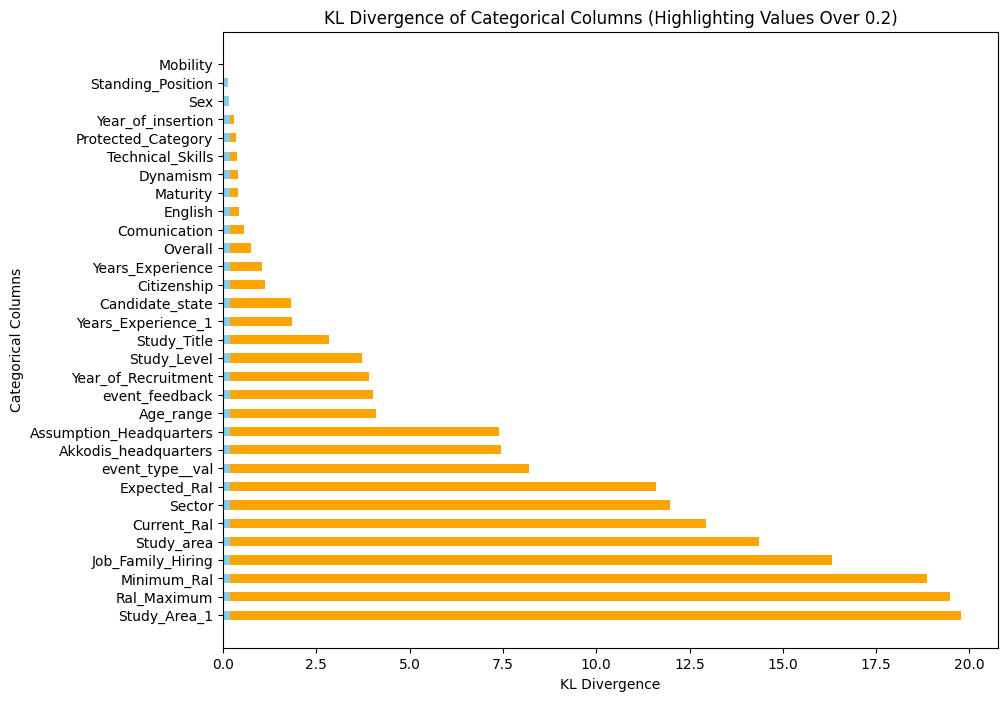

In [8]:
original_data = data
synthetic_data = pd.read_excel("Output_Langchain/combined2.xlsx")
results = []
for col in categorical_columns:
    kl_div = calculate_kl_divergence(original_data[col], synthetic_data[col])
    results.append({"Column": col, "KL Divergence": kl_div})

show_kl_result(results)